Revenue Prediction
==================
In this project the goal is to predict movies revenue using their features. revenue is given by ( box_office - budget ) so the main goal is to predict box office. 

1. Prepare and preprocess the given data. 

2. After exploring data find, select and especially create new features. ignore others.

3. Prepare features to feed the model. 

4. Select and try different models.

5. Document and report each step using relative plots and a brief explanation. finally report the best suited model and justify why did it performed well.



- Keep in mind that in this task accuracy itself only has only part of score.

- Hint: to create new features you can use credit attributes. Think of it this way, what affects box office?  

**Tools** 

importing useful tools and libraries. you may use any other library as well.

In [1766]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import datetime
import ast
from collections import defaultdict


from tabulate import tabulate


# Modelling
from sklearn import preprocessing, svm 
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils import Bunch

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [1767]:
# Your project struct must look like this,


# |── Name_SID.zip
# │   ├── data
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   ├── *.ipynb
# │   ├── document.pdf

df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")


In [1768]:
df_movies.rename(columns={
    'rt_production_budget': 'production_budget',
    'rt_genres': 'movie_genres',
    'rt_website': 'official_website',
    'rt_movie_id': 'movie_id',
    'rt_keywords': 'movie_keywords',
    'rt_original_language': 'original_language',
    'rt_original_title': 'original_title',
    'rt_synopsis': 'synopsis',
    'rt_audience_score': 'audience_score',
    'rt_studios': 'production_studios',
    'rt_production_countries': 'production_countries',
    'rt_release_date': 'release_date',
    'rt_box_office': 'box_office_revenue',
    'rt_runtime': 'movie_runtime',
    'rt_languages': 'languages_available',
    'rt_release_status': 'release_status',
    'rt_tagline': 'movie_tagline',
    'rt_title': 'movie_title',
    'rt_critics_score': 'critics_score',
    'rt_review_count': 'review_count'
}, inplace=True)

df_movies.drop(columns=[
    'official_website', 
    'movie_id', 
    'movie_keywords', 
    'synopsis', 
    'original_title', 
    'audience_score', 
    'production_studios', 
    'box_office_revenue', 
    'release_status', 
    'movie_tagline',
    'movie_title',
    'original_language'
], inplace=True)

df_credit.rename(columns={
    'rt_movie_id': 'movie_id',
    'rt_title': 'movie_title',
    'rt_actors': 'actors',
    'rt_staff': 'staff'
}, inplace=True)

df_credit.drop(columns=[
    'staff',
    'movie_id'
], inplace=True)

df_movies.dropna(inplace=True)
df_movies.dropna(inplace=True)

df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])

genre_weights = {
    'Action': 2.0,
    'Adventure': 1.8,
    'Fantasy': 1.7,
    'Science Fiction': 1.8,
    'Crime': 1.5,
    'Drama': 2.0,
    'Thriller': 1.6, 
    'Animation': 1.5,
    'Family': 1.2,   
    'Western': 1.0,
    'Comedy': 1.7,
    'Romance': 1.3, 
    'Horror': 1.4,
    'Mystery': 1.3,
    'History': 1.2,
    'War': 1.3,
    'Music': 0.9,
    'Documentary': 0.8,
    'Foreign': 0.6,
    'TV Movie': 0.5
}

In [1769]:
def create_dict_from_column(df_column, key_field, value_field):
    result_dict = {}
    for data_str in df_column:
        data_list = json.loads(data_str)
        for item in data_list:
            result_dict[item[key_field]] = item[value_field]
            result_dict[item[value_field]] = item[key_field]
    return result_dict

all_genres_dict = create_dict_from_column(df_movies['movie_genres'], 'id', 'name')
# all_keywords_dict = create_dict_from_column(df_movies['movie_keywords'], 'id', 'name')
# all_studios_dict = create_dict_from_column(df_movies['production_studios'], 'id', 'name')
all_countries_dict = create_dict_from_column(df_movies['production_countries'], 'iso_3166_1', 'name')
all_languages_dict = create_dict_from_column(df_movies['languages_available'], 'iso_639_1', 'name')


In [1770]:
def replace_with_ids_or_iso(data_str, key_field):
    data_list = json.loads(data_str)
    return sorted([item[key_field] for item in data_list])

key_field_map = {
    'movie_genres': 'id',
    # 'movie_keywords': 'id',
    # 'production_studios': 'id',
    'production_countries': 'iso_3166_1',
    'languages_available': 'iso_639_1'
}

for column, key_field in key_field_map.items():
    df_movies[column] = df_movies[column].apply(replace_with_ids_or_iso, key_field=key_field)

columns = [
    'movie_genres',
    'production_countries',
    'languages_available'
]

for column in columns:
    df_movies = df_movies[df_movies[column].apply(lambda x: len(x) > 0)]



Q1 = df_movies['movie_runtime'].quantile(0.25)
Q3 = df_movies['movie_runtime'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


median = df_movies['movie_runtime'].median()
df_movies['movie_runtime'] = df_movies['movie_runtime'].apply(
    lambda x: median if x < lower_bound or x > upper_bound else x 
)


In [1771]:
df_movies.head()


,production_budget,movie_genres,production_countries,release_date,movie_runtime,languages_available,critics_score,review_count
0,237000000,"[12, 14, 28, 878]","[GB, US]",2009-12-10,104.0,"[en, es]",7.2,11800
1,300000000,"[12, 14, 28]",[US],2007-05-19,104.0,[en],6.9,4500
2,245000000,"[12, 28, 80]","[GB, US]",2015-10-26,148.0,"[de, en, es, fr, it]",6.3,4466
3,250000000,"[18, 28, 53, 80]",[US],2012-07-16,104.0,[en],7.6,9106
4,260000000,"[12, 28, 878]",[US],2012-03-07,132.0,[en],6.1,2124


### Q1. Calculate the average production budget per genre in the dataset.


In [1772]:
budget_per_genre = {}

for genre_id, genre_name in all_genres_dict.items():
    if isinstance(genre_id, str):
        continue
    genre_movies = df_movies[df_movies['movie_genres'].apply(lambda genres: genre_id in genres)]
    total_budget = genre_movies['production_budget'].sum()
    count = len(genre_movies)

    budget_per_genre[genre_name] = {'avg': round(total_budget / count, 3), 'budget': total_budget, 'count': count,}

for genre_name, data in budget_per_genre.items():
    print(f"Genre: {genre_name}")
    print(f"    Average Budget:   ${data['avg']:,.2f}")
    print(f"    Total Budget:     ${data['budget']:,.0f}")
    print(f"    Number of Movies: {data['count']}")
    print('-' * 50)

Genre: Action
    Average Budget:   $52,399,211.47
    Total Budget:     $59,368,306,599
    Number of Movies: 1133
--------------------------------------------------
Genre: Adventure
    Average Budget:   $67,109,000.59
    Total Budget:     $52,345,020,462
    Number of Movies: 780
--------------------------------------------------
Genre: Fantasy
    Average Budget:   $64,106,420.46
    Total Budget:     $26,924,696,594
    Number of Movies: 420
--------------------------------------------------
Genre: Science Fiction
    Average Budget:   $52,804,704.50
    Total Budget:     $27,722,469,864
    Number of Movies: 525
--------------------------------------------------
Genre: Crime
    Average Budget:   $28,195,366.05
    Total Budget:     $19,370,216,474
    Number of Movies: 687
--------------------------------------------------
Genre: Drama
    Average Budget:   $21,478,260.18
    Total Budget:     $47,381,041,947
    Number of Movies: 2206
------------------------------------------

### Q2. Top 5 Genres: Country Budget Share Percentages
This section shows the budget share percentages for each country in the top 5 genres, filtering out countries with less than 0.01% share.


In [1773]:
top_5_genres = sorted(budget_per_genre.items(), key=lambda x: x[1]['avg'], reverse=True)[:5]

country_budget_share_percent = {}

for genre_name, budget_data in top_5_genres:
    total_genre_budget = budget_data['budget']
    genre_id = all_genres_dict[genre_name]
    genre_movies = df_movies[df_movies['movie_genres'].apply(lambda genres: genre_id in genres)]

    country_budget_shares = {}

    for movie in genre_movies.itertuples():
        movie_budget = movie.production_budget
        countries = movie.production_countries

        for country_iso in countries:
            if country_iso not in country_budget_shares:
                country_budget_shares[country_iso] = 0
            country_budget_shares[country_iso] += movie_budget / len(countries)

    genre_country_percentages = {
        all_countries_dict[country_iso]: round((budget_share / total_genre_budget) * 100, 2)
        for country_iso, budget_share in country_budget_shares.items()
    }

    genre_country_percentages = {country: percent for country, percent in genre_country_percentages.items() if percent >= 0.01}
    genre_country_percentages = dict(sorted(genre_country_percentages.items(), key=lambda item: item[1], reverse=True))
    country_budget_share_percent[genre_name] = genre_country_percentages

country_budget_share_percent = dict(sorted(country_budget_share_percent.items(), key=lambda item: sum(item[1].values()), reverse=True))


for genre_name, budget_data in top_5_genres:
    print(f"Genre: {genre_name}")
    print("-" * (len(genre_name) + 7))

    for country, budget_share in country_budget_share_percent[genre_name].items():
        print(f"\t{country:<25} | Budget Share: {budget_share:>10.2f} %")

    print("\n" + "=" * 70)
    print()


Genre: Animation
----------------
	United States of America  | Budget Share:      87.24 %
	United Kingdom            | Budget Share:       2.59 %
	Australia                 | Budget Share:       1.98 %
	Japan                     | Budget Share:       1.77 %
	France                    | Budget Share:       1.42 %
	Germany                   | Budget Share:       1.36 %
	New Zealand               | Budget Share:       0.68 %
	China                     | Budget Share:       0.55 %
	India                     | Budget Share:       0.44 %
	Russia                    | Budget Share:       0.32 %
	Canada                    | Budget Share:       0.31 %
	South Africa              | Budget Share:       0.26 %
	Finland                   | Budget Share:       0.24 %
	Spain                     | Budget Share:       0.22 %
	Mexico                    | Budget Share:       0.16 %
	Belgium                   | Budget Share:       0.15 %
	Hong Kong                 | Budget Share:       0.14 %
	Argentina    

### Q3. Filtering movies from the past 10 years, counting the number of movies with exactly 3 genres per year, and displaying the results.


In [1774]:
current_year = datetime.datetime.now().year
df_movies_past_10_years = df_movies[df_movies['release_date'].dt.year >= (current_year - 10)]
df_movies_exactly_3_genres = df_movies[df_movies['release_date'].dt.year >= (current_year - 10)].copy()
df_movies_exactly_3_genres['year'] = df_movies_exactly_3_genres['release_date'].dt.year
movies_count_per_year = df_movies_exactly_3_genres.groupby('year').size()
for year, count in movies_count_per_year.items():
    print(f"Year:   {year}   -   Movies Count:   {count}")

Year:   2015   -   Movies Count:   197
Year:   2016   -   Movies Count:   97


#### Q4. Calculates and prints the average movie runtime per country, sorted in descending order of runtime. Filters invalid movies, then aggregates and computes the average runtime for each country.


In [1775]:
country_avg_runtime = {}

def is_not_valid(movie):
    if pd.isna(movie.movie_runtime):
        return True
    if not isinstance(movie.movie_runtime, float):
        return True
    if len(movie.production_countries) == 0:
        return True
    return False

for movie in df_movies.itertuples():
    if is_not_valid(movie):
        continue

    countries = movie.production_countries
    runtime = movie.movie_runtime

    for country_iso in countries:
        country = all_countries_dict[country_iso]
        if country not in country_avg_runtime:
            country_avg_runtime[country] = {'total_runtime': 0, 'movie_count': 0}
        country_avg_runtime[country]['total_runtime'] += runtime
        country_avg_runtime[country]['movie_count'] += 1

country_avg_runtime = {
    country: round(data['total_runtime'] / data['movie_count'], 2)
    for country, data in country_avg_runtime.items()
}

sorted_country_avg_runtime = dict(sorted(country_avg_runtime.items(), key=lambda item: item[1], reverse=True))
print("Country-wise Average Movie Runtime:")
print("-" * 50)

for country, avg_runtime in sorted_country_avg_runtime.items():
    print(f"{country:<25} | Average Runtime: {avg_runtime:>10} minutes")

print("-" * 50)


Country-wise Average Movie Runtime:
--------------------------------------------------
Dominica                  | Average Runtime:      151.0 minutes
Kyrgyz Republic           | Average Runtime:      135.0 minutes
Portugal                  | Average Runtime:      133.0 minutes
Jamaica                   | Average Runtime:      130.5 minutes
Morocco                   | Average Runtime:      130.5 minutes
Slovakia                  | Average Runtime:      130.5 minutes
Philippines               | Average Runtime:      130.0 minutes
Malta                     | Average Runtime:     128.25 minutes
Ukraine                   | Average Runtime:      127.0 minutes
Serbia and Montenegro     | Average Runtime:      123.0 minutes
Malaysia                  | Average Runtime:      122.5 minutes
Turkey                    | Average Runtime:      122.0 minutes
Czech Republic            | Average Runtime:     121.79 minutes
Guyana                    | Average Runtime:      120.0 minutes
Bahamas          

#### Q5. This code counts the occurrences of each non-English language in the movies dataset, excluding English, and displays the results in a formatted table showing the language, its ISO code, and the count of movies in that language.


In [1776]:
languages_count = {}
for movie in df_movies.itertuples():
    for language in movie.languages_available:
        if all_languages_dict[language] == "":
            all_languages_dict[language] = "Unknown Language"
        language_full = all_languages_dict[language]
        if language_full != 'English':
            if all_languages_dict[language] == "Unknown Language":
                languages_count.setdefault(language_full, {'count': 0, 'iso': "Unknown Iso" })['count'] += 1
            else:
                languages_count.setdefault(language_full, {'count': 0, 'iso': language })['count'] += 1


sorted_languages = sorted(languages_count.items(), key=lambda item: item[1]['count'], reverse=True)
print(tabulate([[language, data['iso'], data['count']] for language, data in sorted_languages], headers=["Language", "Iso Code", "Movie Count"], tablefmt="grid"))

+------------------+-------------+---------------+
| Language         | Iso Code    |   Movie Count |
+==================+=============+===============+
| Français         | fr          |           436 |
+------------------+-------------+---------------+
| Español          | es          |           347 |
+------------------+-------------+---------------+
| Deutsch          | de          |           256 |
+------------------+-------------+---------------+
| Pусский          | ru          |           184 |
+------------------+-------------+---------------+
| Italiano         | it          |           183 |
+------------------+-------------+---------------+
| 普通话           | zh          |           106 |
+------------------+-------------+---------------+
| 日本語           | ja          |            97 |
+------------------+-------------+---------------+
| Português        | pt          |            68 |
+------------------+-------------+---------------+
| العربية          | ar          |   

<!-- #### Q6. This code calculates the average production budget per year for movies produced in the USA over the past 10 years, adjusting for shared production between countries and providing a detailed breakdown by year. -->


In [1777]:
current_year = datetime.datetime.now().year

budget_per_year = {}
total_budget = 0

for movie in df_movies.itertuples():
    if pd.isna(movie.release_date):
        continue
    release_year = pd.to_datetime(movie.release_date).year
    if release_year < current_year - 10:
        continue
    if 'US' not in movie.production_countries:
        continue

    proportional_budget = movie.production_budget / len(movie.production_countries)
    total_budget += proportional_budget

    if release_year not in budget_per_year:
        budget_per_year[release_year] = 0
    budget_per_year[release_year] += proportional_budget

print("Average Budget Per Year (Past 10 Years):")
print("-" * 50)
for year in sorted(budget_per_year.keys()):
    avg_budget = budget_per_year[year]
    print(f"{year}: ${avg_budget:,.2f}")
print("-" * 50)
print(f"Total Budget (Past 10 Years): ${total_budget:,.2f}")


Average Budget Per Year (Past 10 Years):
--------------------------------------------------
2015: $5,221,633,336.33
2016: $3,546,900,000.00
--------------------------------------------------
Total Budget (Past 10 Years): $8,768,533,336.33


#### Q7. This code calculates the average production budget per year for movies produced over the past 10 years, adjusting for shared production between countries and providing a detailed breakdown by year.


In [1778]:
current_year = datetime.datetime.now().year

budget_per_year = {}
total_budget = 0

for movie in df_movies.itertuples():
    if pd.isna(movie.release_date):
        continue
    release_year = pd.to_datetime(movie.release_date).year
    if release_year < current_year - 10:
        continue

    total_budget += movie.production_budget

    if release_year not in budget_per_year:
        budget_per_year[release_year] = 0
    budget_per_year[release_year] += movie.production_budget

print("Average Budget Per Year (Past 10 Years):")
print("-" * 50)
for year in sorted(budget_per_year.keys()):
    avg_budget = budget_per_year[year]
    print(f"{year}: ${avg_budget:,.2f}")
print("-" * 50)
print(f"Total Budget (Past 10 Years): ${total_budget:,.2f}")


Average Budget Per Year (Past 10 Years):
--------------------------------------------------
2015: $6,699,297,363.00
2016: $4,749,390,000.00
--------------------------------------------------
Total Budget (Past 10 Years): $11,448,687,363.00


### Q8. Extracting Johnny Depp Movies
This script filters movies featuring Johnny Depp from a dataset and displays them in a neatly formatted list.


In [1779]:
def has_johnny_depp(actors):
    actors_list = ast.literal_eval(actors)
    return any(actor['name'] == "Johnny Depp" for actor in actors_list)

df_johnny_depp_movies = df_credit[df_credit['actors'].apply(has_johnny_depp)]

print(f"{'Idx':<4} {'Movie Title':<50}")
print("=" * 55)

for idx, title in enumerate(df_johnny_depp_movies['movie_title'], start=1):
    print(f"{idx:<4} {title:<50}")


Idx  Movie Title                                       
1    Pirates of the Caribbean: At World's End          
2    Pirates of the Caribbean: Dead Man's Chest        
3    The Lone Ranger                                   
4    Pirates of the Caribbean: On Stranger Tides       
5    Alice in Wonderland                               
6    Alice Through the Looking Glass                   
7    Charlie and the Chocolate Factory                 
8    Dark Shadows                                      
9    Rango                                             
10   Pirates of the Caribbean: The Curse of the Black Pearl
11   Public Enemies                                    
12   The Tourist                                       
13   Transcendence                                     
14   Jack and Jill                                     
15   Mortdecai                                         
16   Black Mass                                        
17   Into the Woods                         

#### Q9. This script calculates and prints the gender distribution of actors in the first five orders (1-5) for each movie in the dataset. It outputs the percentage of male and female actors for each order in a clear, formatted table.


In [1780]:
def get_gender_counts_by_order(actors_list):
    gender_counts_by_order = defaultdict(lambda: {'male': 0, 'female': 0})

    for actor in actors_list:
        order = actor['order']
        if order >= 5:
            continue
        gender = 'male' if actor['gender'] == 2 else 'female'
        gender_counts_by_order[order][gender] += 1

    return gender_counts_by_order

total_gender_by_order = defaultdict(lambda: {'male': 0, 'female': 0})
total_actors_by_order = defaultdict(int)

for actors_str in df_credit['actors']:
    actors_list = ast.literal_eval(actors_str)

    if len(actors_list) < 5:
        continue

    gender_counts_by_order = get_gender_counts_by_order(actors_list)

    for order, counts in gender_counts_by_order.items():
        total_gender_by_order[order]['male'] += counts['male']
        total_gender_by_order[order]['female'] += counts['female']
        total_actors_by_order[order] += counts['male'] + counts['female']

gender_percentage_by_order = {}
for order in total_gender_by_order:
    male_count = total_gender_by_order[order]['male']
    female_count = total_gender_by_order[order]['female']
    total_count = total_actors_by_order[order]

    male_percentage = (male_count / total_count) * 100 if total_count > 0 else 0
    female_percentage = (female_count / total_count) * 100 if total_count > 0 else 0

    gender_percentage_by_order[order] = {
        'male_percentage': male_percentage,
        'female_percentage': female_percentage
    }

print("Gender Distribution by Actor Order (1-5):")
print("-" * 50)
for order, percentages in gender_percentage_by_order.items():
    print(f"Order {order + 1}: Male: {percentages['male_percentage']:.2f}% | Female: {percentages['female_percentage']:.2f}%")


Gender Distribution by Actor Order (1-5):
--------------------------------------------------
Order 1: Male: 70.98% | Female: 29.02%
Order 2: Male: 54.85% | Female: 45.15%
Order 3: Male: 55.32% | Female: 44.68%
Order 4: Male: 56.72% | Female: 43.28%
Order 5: Male: 57.95% | Female: 42.05%


#### Q11. Sorts and displays average review and critics scores for each genre by year, in descending order, for the past 10 years.


In [1781]:
import datetime

current_year = datetime.datetime.now().year

genre_in_every_year = {}

for movie in df_movies.itertuples():
    year = movie.release_date.year
    if current_year - 10 > year or not movie.movie_genres:
        continue
    for genre_id in movie.movie_genres:
        genre = all_genres_dict[genre_id]
        if year not in genre_in_every_year:
            genre_in_every_year[year] = {}
        if genre not in genre_in_every_year[year]:
            genre_in_every_year[year][genre] = {'review_count': 0, 'critics_score': 0, 'count': 0}

        genre_in_every_year[year][genre]['review_count'] += movie.review_count
        genre_in_every_year[year][genre]['critics_score'] += movie.critics_score
        genre_in_every_year[year][genre]['count'] += 1

for year in sorted(genre_in_every_year.keys()):
    print(f"Year: {year}")
    print("-" * (len(str(year)) + 5))

    print("Average Review Score:")
    sorted_genres_by_review = sorted(genre_in_every_year[year].items(), key=lambda x: x[1]['review_count'] / x[1]['count'] if x[1]['count'] != 0 else 0, reverse=True)
    for genre, data in sorted_genres_by_review:
        avg_review_score = data['review_count'] / data['count'] if data['count'] != 0 else 0
        print(f"\t{genre:<25} | Average Review Score: {avg_review_score:>10.2f}")

    print("\nAverage Critics Score:")
    sorted_genres_by_critics = sorted(genre_in_every_year[year].items(), key=lambda x: x[1]['critics_score'] / x[1]['count'] if x[1]['count'] != 0 else 0, reverse=True)
    for genre, data in sorted_genres_by_critics:
        avg_critics_score = data['critics_score'] / data['count'] if data['count'] != 0 else 0
        print(f"\t{genre:<25} | Average Critics Score: {avg_critics_score:>10.2f}")
    
    print("\n" + "=" * 70)
    print()


Year: 2015
---------
Average Review Score:
	Science Fiction           | Average Review Score:    2688.85
	Adventure                 | Average Review Score:    2603.94
	Action                    | Average Review Score:    1840.29
	Western                   | Average Review Score:    1648.71
	Family                    | Average Review Score:    1614.47
	Animation                 | Average Review Score:    1581.75
	Fantasy                   | Average Review Score:    1231.60
	Thriller                  | Average Review Score:    1153.78
	Crime                     | Average Review Score:    1047.04
	Drama                     | Average Review Score:     985.63
	Comedy                    | Average Review Score:     958.10
	Mystery                   | Average Review Score:     899.47
	Romance                   | Average Review Score:     847.59
	History                   | Average Review Score:     733.00
	Music                     | Average Review Score:     611.25
	Horror                    

# Here is the start of machine learning

In [1782]:
df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")

In [1783]:
df_credit.head()

,rt_movie_id,rt_title,rt_actors,rt_staff
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [1784]:
df_movies.head()

,rt_production_budget,rt_genres,rt_website,rt_movie_id,rt_keywords,rt_original_language,rt_original_title,rt_synopsis,rt_audience_score,rt_studios,rt_production_countries,rt_release_date,rt_box_office,rt_runtime,rt_languages,rt_release_status,rt_tagline,rt_title,rt_critics_score,rt_review_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [1785]:
df_movies = df_movies[df_movies['rt_box_office']!=0]
y = df_movies['rt_box_office']
X = df_movies.drop(columns='rt_box_office')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

In [1786]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns



numerical_transformer = preprocessing.StandardScaler()
categorical_transformer = preprocessing.OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

def evaluate_pipeline(model_name, pipeline, X_train, y_train, X_test, y_test, is_classification=False):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    if is_classification:
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred, output_dict=True)
        }
    else:
        metrics = {
            "mse": mean_squared_error(y_test, y_pred),
            "mae": mean_absolute_error(y_test, y_pred),
            "r2": r2_score(y_test, y_pred)
        }
    return Bunch(model=model_name, pipeline=pipeline, metrics=metrics, predictions=y_pred)

linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

random_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

svr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR())
])

log_transformer = FunctionTransformer(np.log1p, validate=True)
y_train_log = log_transformer.transform(y_train.values.reshape(-1, 1))
y_test_log = log_transformer.transform(y_test.values.reshape(-1, 1))

results = {
    "linear": evaluate_pipeline("Linear Regression", linear_model, X_train, y_train_log, X_test, y_test_log),
    "random_forest": evaluate_pipeline("Random Forest", random_forest_model, X_train, y_train_log, X_test, y_test_log),
    "svr": evaluate_pipeline("SVR", svr_model, X_train, y_train_log, X_test, y_test_log)
}

y_train_binary = (y_train > y_train.median()).astype(int)
y_test_binary = (y_test > y_test.median()).astype(int)
results["logistic"] = evaluate_pipeline("Logistic Regression", logistic_model, X_train, y_train_binary, X_test, y_test_binary, is_classification=True)


results_summary = {model_name: result.metrics for model_name, result in results.items()}
print("Model Evaluation Summary:")
print("=" * 40)
for model_name, metrics in results_summary.items():
    print(f"Model: {model_name}")
    if "accuracy" in metrics:
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print("  Classification Report:")
        for key, value in metrics['classification_report'].items():
            if key != 'accuracy':
                print(f"    {key}: {value}")
    else:
        print(f"  MSE: {metrics['mse']:.4f}")
        print(f"  MAE: {metrics['mae']:.4f}")
        print(f"  R2: {metrics['r2']:.4f}")
    print("-" * 40)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Evaluation Summary:
Model: linear
  MSE: 3.3989
  MAE: 1.1045
  R2: 0.3584
----------------------------------------
Model: random_forest
  MSE: 2.5249
  MAE: 0.8530
  R2: 0.5234
----------------------------------------
Model: svr
  MSE: 2.6791
  MAE: 0.9894
  R2: 0.4943
----------------------------------------
Model: logistic
  Accuracy: 0.8211
  Classification Report:
    0: {'precision': 0.7926565874730022, 'recall': 0.8696682464454977, 'f1-score': 0.8293785310734463, 'support': 422.0}
    1: {'precision': 0.8556430446194225, 'recall': 0.7725118483412322, 'f1-score': 0.8119551681195517, 'support': 422.0}
    macro avg: {'precision': 0.8241498160462124, 'recall': 0.8210900473933649, 'f1-score': 0.820666849596499, 'support': 844.0}
    weighted avg: {'precision': 0.8241498160462123, 'recall': 0.8210900473933649, 'f1-score': 0.820666849596499, 'support': 844.0}
----------------------------------------


In [1787]:
df_movies.rename(columns={
    'rt_production_budget': 'production_budget',
    'rt_genres': 'movie_genres',
    'rt_website': 'official_website',
    'rt_movie_id': 'movie_id',
    'rt_keywords': 'movie_keywords',
    'rt_original_language': 'original_language',
    'rt_original_title': 'original_title',
    'rt_synopsis': 'synopsis',
    'rt_audience_score': 'audience_score',
    'rt_studios': 'production_studios',
    'rt_production_countries': 'production_countries',
    'rt_release_date': 'release_date',
    'rt_box_office': 'box_office_revenue',
    'rt_runtime': 'movie_runtime',
    'rt_languages': 'languages_available',
    'rt_release_status': 'release_status',
    'rt_tagline': 'movie_tagline',
    'rt_title': 'movie_title',
    'rt_critics_score': 'critics_score',
    'rt_review_count': 'review_count'
}, inplace=True)


In [1788]:
def create_dict_from_column(df_column, key_field, value_field):
    result_dict = {}
    for data_str in df_column:
        data_list = json.loads(data_str)
        for item in data_list:
            result_dict[item[key_field]] = item[value_field]
    return result_dict

all_genres_dict = create_dict_from_column(df_movies['movie_genres'], 'id', 'name')
all_keywords_dict = create_dict_from_column(df_movies['movie_keywords'], 'id', 'name')
all_studios_dict = create_dict_from_column(df_movies['production_studios'], 'id', 'name')
all_countries_dict = create_dict_from_column(df_movies['production_countries'], 'iso_3166_1', 'name')
all_languages_dict = create_dict_from_column(df_movies['languages_available'], 'iso_639_1', 'name')


In [1789]:
def replace_with_ids_or_iso(data_str, key_field):
    data_list = json.loads(data_str)
    return sorted([item[key_field] for item in data_list])

key_field_map = {
    'movie_genres': 'id',
    'movie_keywords': 'id',
    'production_studios': 'id',
    'production_countries': 'iso_3166_1',
    'languages_available': 'iso_639_1'
}

for column, key_field in key_field_map.items():
    df_movies[column] = df_movies[column].apply(lambda x: replace_with_ids_or_iso(x, key_field))


In [1790]:
df_movies.head()

,production_budget,movie_genres,official_website,movie_id,movie_keywords,original_language,original_title,synopsis,audience_score,production_studios,production_countries,release_date,box_office_revenue,movie_runtime,languages_available,release_status,movie_tagline,movie_title,critics_score,review_count
0,237000000,"[12, 14, 28, 878]",http://www.avatarmovie.com/,19995,"[1463, 2964, 3386, 3388, 3679, 3801, 9685, 984...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[289, 306, 444, 574]","[GB, US]",2009-12-10,2787965087,162.0,"[en, es]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[12, 14, 28]",http://disney.go.com/disneypictures/pirates/,285,"[270, 726, 911, 1319, 2038, 2052, 2580, 2660, ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[2, 130, 19936]",[US],2007-05-19,961000000,169.0,[en],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[12, 28, 80]",http://www.sonypictures.com/movies/spectre/,206647,"[470, 818, 4289, 9663, 14555, 156095, 158431]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[5, 10761, 69434]","[GB, US]",2015-10-26,880674609,148.0,"[de, en, es, fr, it]",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[18, 28, 53, 80]",http://www.thedarkknightrises.com/,49026,"[849, 853, 949, 1308, 1437, 3051, 3562, 6969, ...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[923, 6194, 9993, 9996]",[US],2012-07-16,1084939099,165.0,[en],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[12, 28, 878]",http://movies.disney.com/john-carter,49529,"[818, 839, 1456, 3801, 7376, 9951, 10028, 1053...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[2],[US],2012-03-07,284139100,132.0,[en],Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [1791]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3376 entries, 0 to 4798
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   production_budget     3376 non-null   int64  
 1   movie_genres          3376 non-null   object 
 2   official_website      1396 non-null   object 
 3   movie_id              3376 non-null   int64  
 4   movie_keywords        3376 non-null   object 
 5   original_language     3376 non-null   object 
 6   original_title        3376 non-null   object 
 7   synopsis              3376 non-null   object 
 8   audience_score        3376 non-null   float64
 9   production_studios    3376 non-null   object 
 10  production_countries  3376 non-null   object 
 11  release_date          3376 non-null   object 
 12  box_office_revenue    3376 non-null   int64  
 13  movie_runtime         3376 non-null   float64
 14  languages_available   3376 non-null   object 
 15  release_status        3376

In [1792]:
df_movies['box_office_revenue']

0       2787965087
1        961000000
2        880674609
3       1084939099
4        284139100
           ...    
4775         76901
4788       6000000
4792         99000
4796        424760
4798       2040920
Name: box_office_revenue, Length: 3376, dtype: int64

In [1793]:
df_movies = df_movies[df_movies['box_office_revenue']!=0]
y = df_movies['box_office_revenue']
X = df_movies.drop(columns='box_office_revenue')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

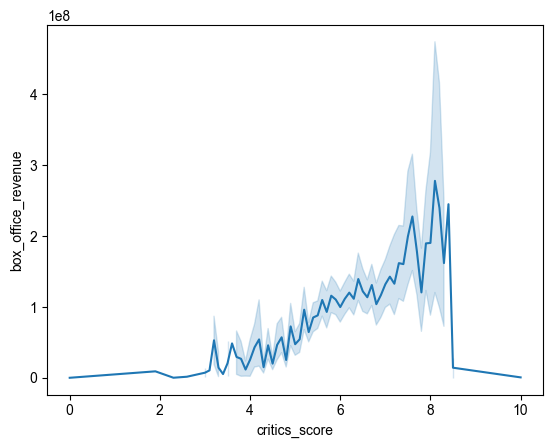

In [1794]:
sns.lineplot(x='critics_score', y='box_office_revenue', data=df_movies)
sns.set_style('dark')

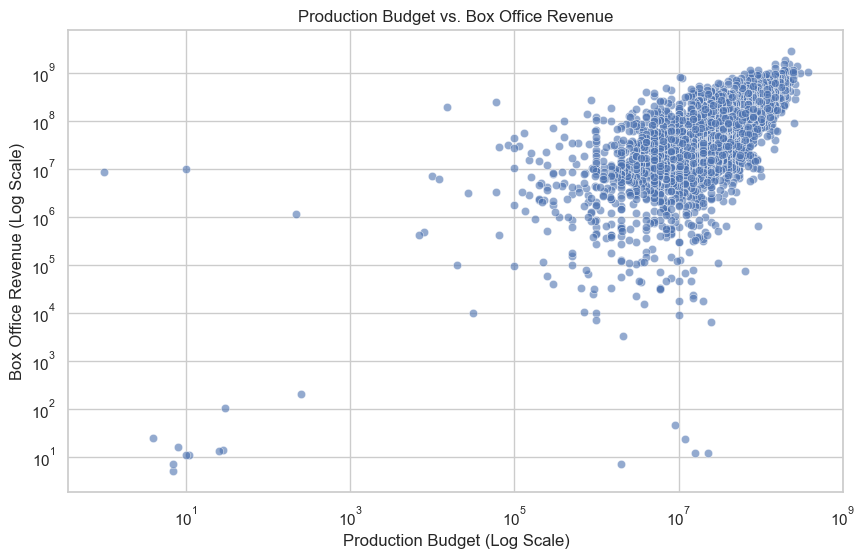

In [1795]:
sns.set(style="whitegrid")

# Scatter plot: Budget vs. Box Office Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_movies['production_budget'], 
    y=df_movies['box_office_revenue'],
    alpha=0.6
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Production Budget (Log Scale)")
plt.ylabel("Box Office Revenue (Log Scale)")
plt.title("Production Budget vs. Box Office Revenue")
plt.show()


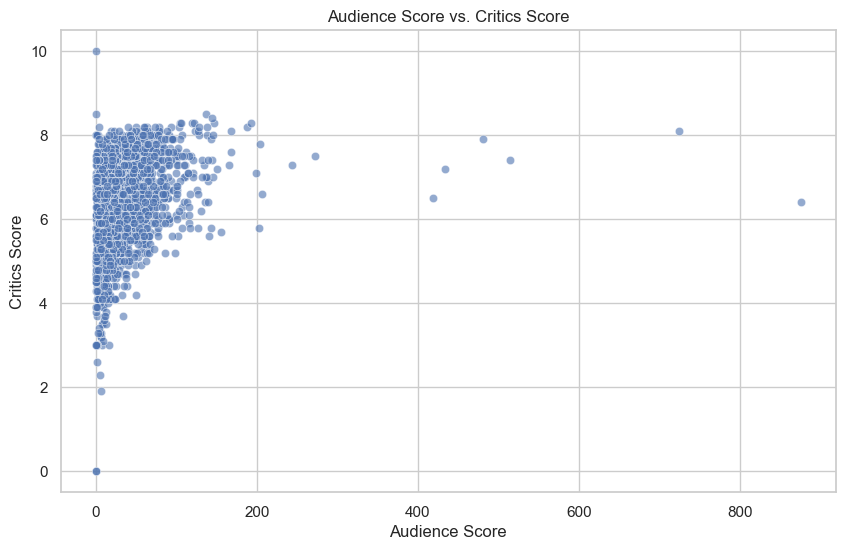

In [1796]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_movies['audience_score'], 
    y=df_movies['critics_score'],
    alpha=0.6
)
plt.xlabel("Audience Score")
plt.ylabel("Critics Score")
plt.title("Audience Score vs. Critics Score")
plt.show()

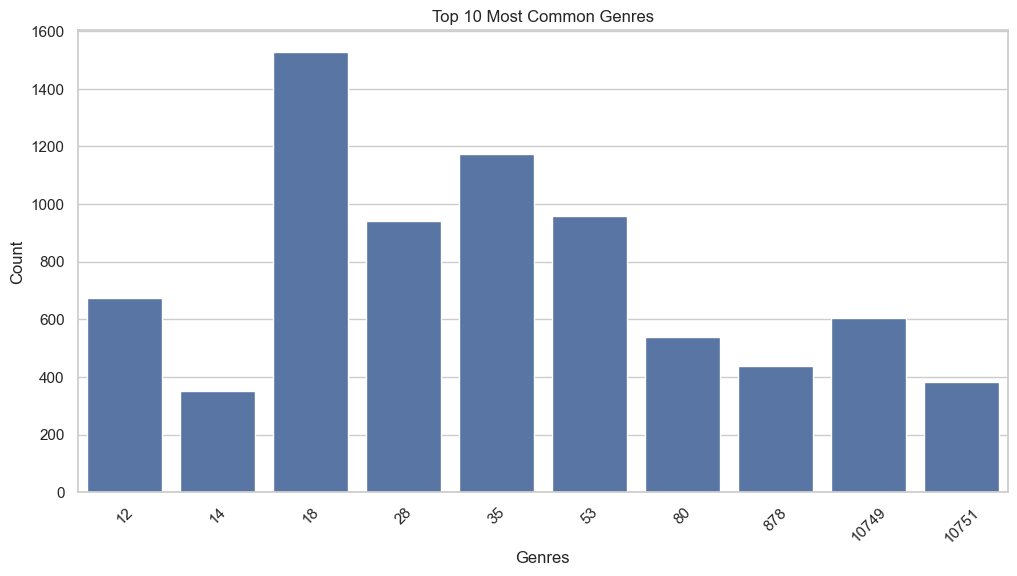

In [1797]:
plt.figure(figsize=(12, 6))
genre_counts = df_movies['movie_genres'].explode().value_counts().head(10)
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Top 10 Most Common Genres")
plt.xticks(rotation=45)
plt.show()

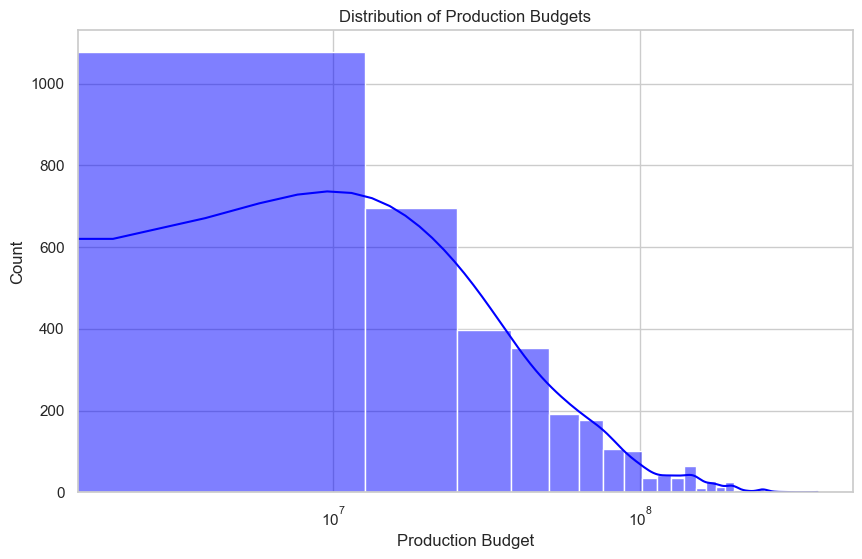

In [1798]:
plt.figure(figsize=(10, 6))
sns.histplot(df_movies['production_budget'], bins=30, kde=True, color='blue')
plt.xscale("log")
plt.xlabel("Production Budget")
plt.ylabel("Count")
plt.title("Distribution of Production Budgets")
plt.show()

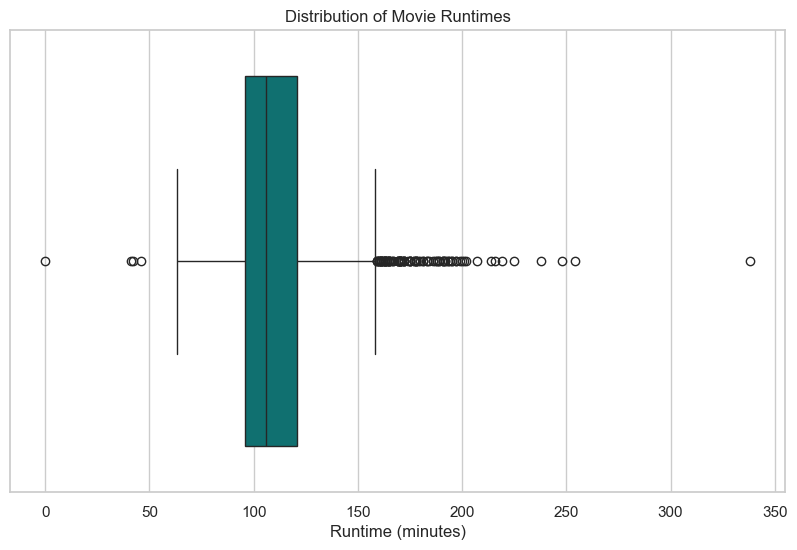

In [1799]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_movies['movie_runtime'], color="teal")
plt.xlabel("Runtime (minutes)")
plt.title("Distribution of Movie Runtimes")
plt.show()

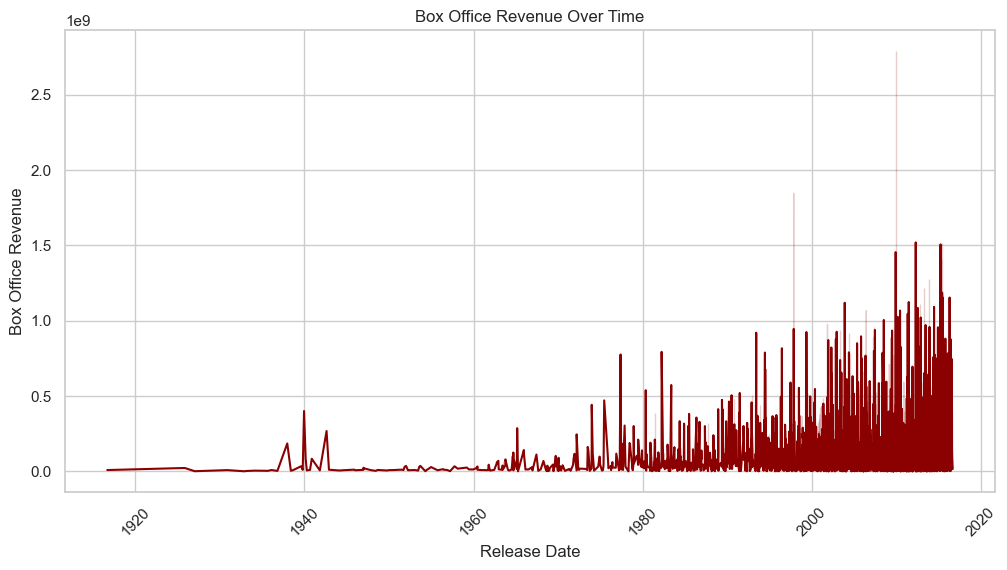

In [1800]:
df_movies['release_date'] = pd.to_datetime(df_movies["release_date"], errors='coerce')
df_movies = df_movies.sort_values(by="release_date")
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_movies["release_date"], y=df_movies['box_office_revenue'], color="darkred")
plt.xlabel("Release Date")
plt.ylabel("Box Office Revenue")
plt.title("Box Office Revenue Over Time")
plt.xticks(rotation=45)
plt.show()

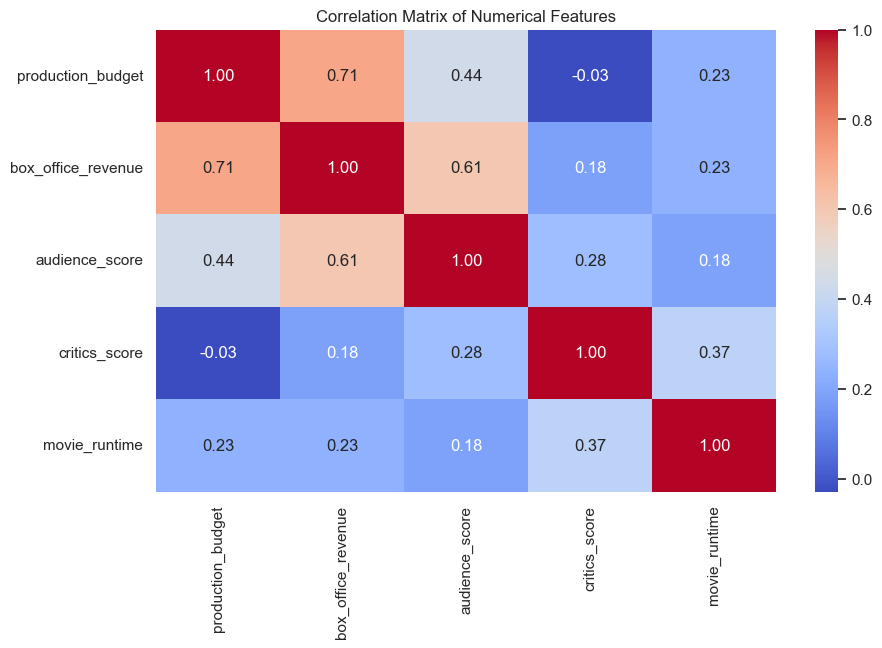

In [1801]:
plt.figure(figsize=(10, 6))
corr_matrix = df_movies[['production_budget', "box_office_revenue", "audience_score", "critics_score", "movie_runtime"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()